In [ ]:

import pandas as pd
csv_path = './Data/csv'
artist_train = pd.read_csv('./Data/csv/Artist/artist_train')
# lets visualize one imag
base_url = './Data/image/wikiart'

In [ ]:
# lets start creating data
artist = './Data/csv/Artist'
genre = './Data/csv/Genre'
style = './Data/csv/Style'

data_dir = './Data/csv'
# artist_train = artist + '/artist_train'
# artist_val = artist + '/artist_val'
# artist_class = artist + '/artist_class.txt'

# genre_train = genre + '/genre_train.csv'
# genre_val = genre + '/genre_val.csv'
# genre_class = genre + '/genre_class.txt'

# style_train = style + '/style_train.csv'
# style_val = style + '/style_val.csv'
# style_class = style + '/style_class.txt'

artist_train_path = data_dir + '/artist_train.csv'
artist_val_path = data_dir + '/artist_val.csv'
artist_class_path = data_dir + '/artist_class.txt'

genre_train_path = data_dir + '/genre_train.csv'
genre_val_path = data_dir + '/genre_val.csv'
genre_class_path = data_dir + '/genre_class.txt'

style_train_path = data_dir + '/style_train.csv'
style_val_path = data_dir + '/style_val.csv'
style_class_path = data_dir + '/style_class.txt'



artist_train = pd.read_csv(data_dir + '/artist_train.csv')
artist_val = pd.read_csv(data_dir + '/artist_val.csv')
artist_class = pd.read_csv(data_dir + '/artist_class.txt')

genre_train = pd.read_csv(data_dir + '/genre_train.csv')
genre_val = pd.read_csv(data_dir + '/genre_val.csv')
genre_class = pd.read_csv(data_dir + '/genre_class.txt')

style_train = pd.read_csv(data_dir + '/style_train.csv')
style_val = pd.read_csv(data_dir + '/style_val.csv')
style_class = pd.read_csv(data_dir + '/style_class.txt')




artist_train[:4]

path  class_no
0  Realism/vincent-van-gogh_pine-trees-in-the-fen...        22
1  Baroque/rembrandt_the-angel-appearing-to-the-s...        20
2  Post_Impressionism/paul-cezanne_portrait-of-th...        16
3  Impressionism/pierre-auguste-renoir_young-girl...        17

Creating balanced artist dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|█████████████████████████████████████████████████████████| 13344/13344 [00:02<00:00, 6538.13it/s]


Balancing dataset...


Processing classes: 100%|███████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 11122.91it/s]


Filling missing slots...
Shuffling dataset...
Artist balanced dataset size: 736


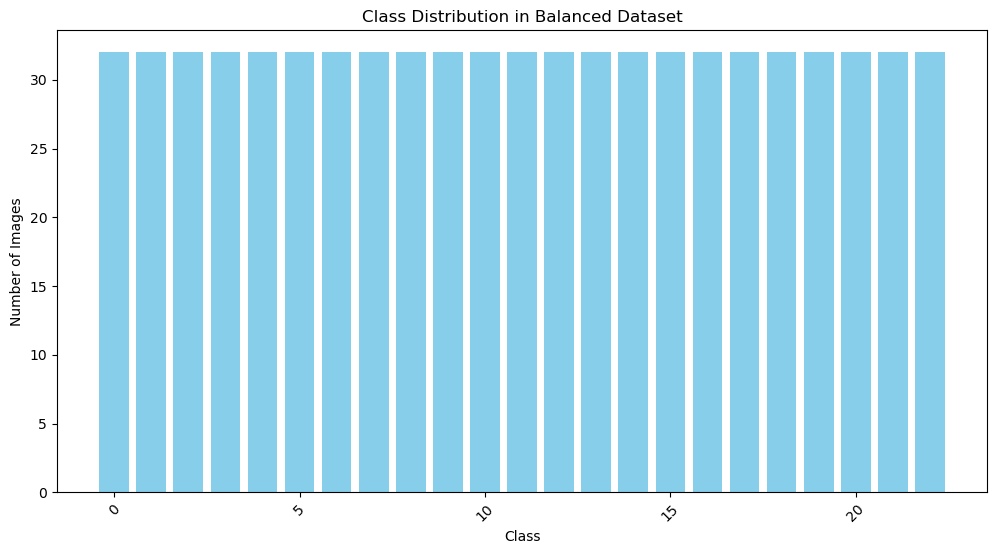

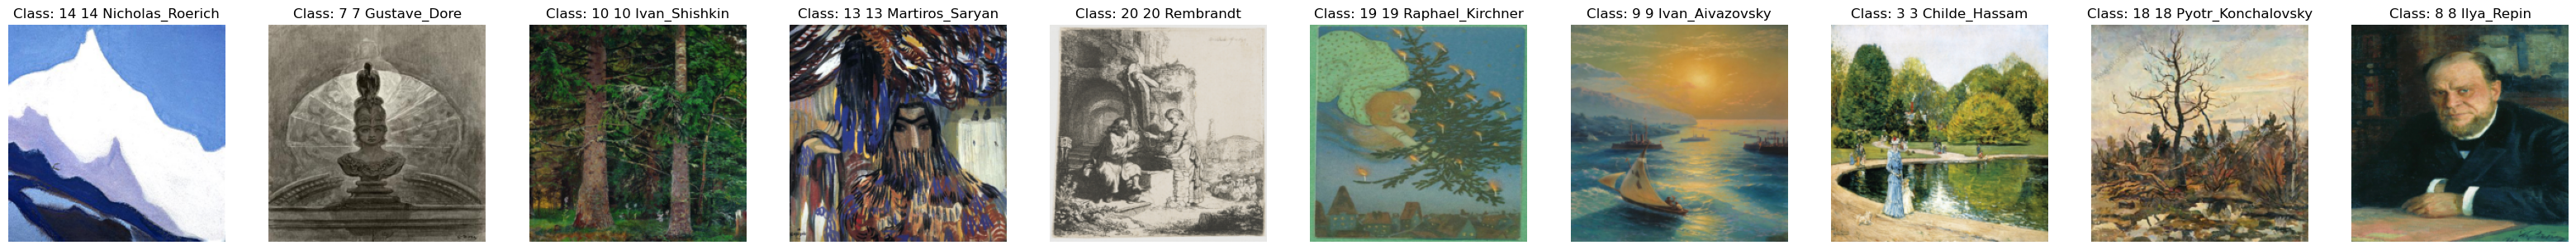

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define dataset class
class BalancedArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_mapping, transform=None, images_per_class=32):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.images_per_class = images_per_class

        # Filter out missing images
        print("Filtering missing images...")
        self.data = self.data[self.data.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, str(x))))]

        # Group images by class
        print("Grouping images by class...")
        self.class_images = defaultdict(list)
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing rows"):
            self.class_images[row.iloc[1]].append(row)

        # Balance dataset with 32 images per class
        print("Balancing dataset...")
        self.final_data = []
        all_images = []
        for cls, images in tqdm(self.class_images.items(), total=len(self.class_images), desc="Processing classes"):
            if len(images) >= images_per_class:
                selected_images = random.sample(images, images_per_class)
            else:
                selected_images = images[:]
                all_images.extend(images)  # Store extra images for filling
            self.final_data.extend(selected_images)

        # Fill missing slots with extra images
        print("Filling missing slots...")
        needed_images = images_per_class * len(self.class_images) - len(self.final_data)
        if needed_images > 0:
            self.final_data.extend(random.sample(all_images, min(needed_images, len(all_images))))

        # Shuffle dataset
        print("Shuffling dataset...")
        random.shuffle(self.final_data)

        # Count images per class
        self.class_counts = defaultdict(int)
        for row in self.final_data:
            self.class_counts[row.iloc[1]] += 1

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        row = self.final_data[idx]
        img_path = os.path.join(self.img_dir, str(row.iloc[0]))
        label = row.iloc[1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    def visualize_class_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution in Balanced Dataset")
        plt.xticks(rotation=45)
        plt.show()

    def visualize_samples(self, num_samples=10):
        fig, axes = plt.subplots(1, num_samples, figsize=(40, 20))
        for i in range(num_samples):
            image, label = self.__getitem__(random.randint(0, len(self) - 1))
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {label} {artist_class['class_name'][label]}")
            axes[i].axis("off")
        plt.show()

    # Function to compare artist and genre relationships



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create balanced artist dataset
print("Creating balanced artist dataset...")
artist_balanced_dataset = BalancedArtDataset(artist_train_path, "./Data/image/wikiart", artist_class_path, transform=transform, images_per_class=32)

# Check dataset length
print("Artist balanced dataset size:", len(artist_balanced_dataset))

# Visualize class distribution
artist_balanced_dataset.visualize_class_distribution()

# Visualize sample images
artist_balanced_dataset.visualize_samples(num_samples=10)


In [ ]:
artist_class['class_name'][0]

'0 Albrecht_Durer'

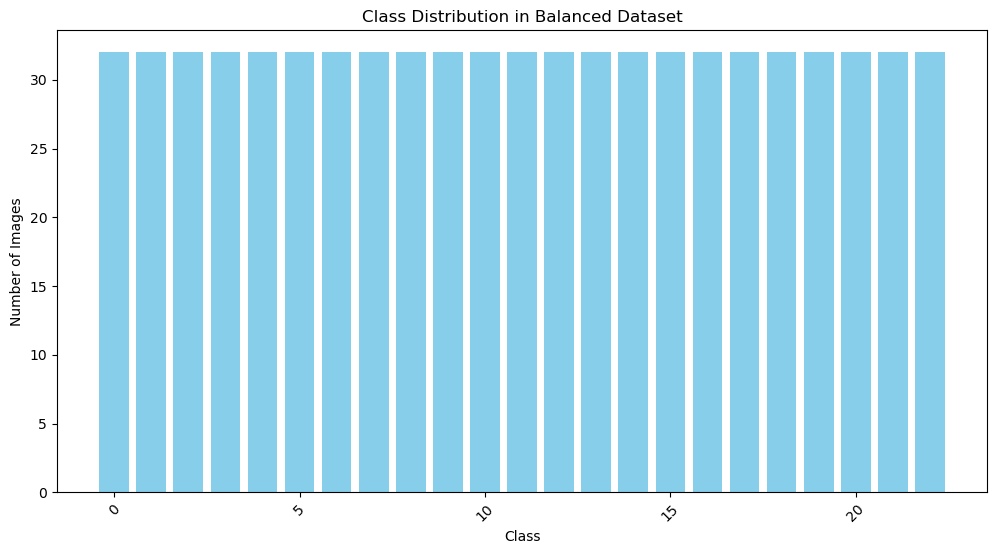

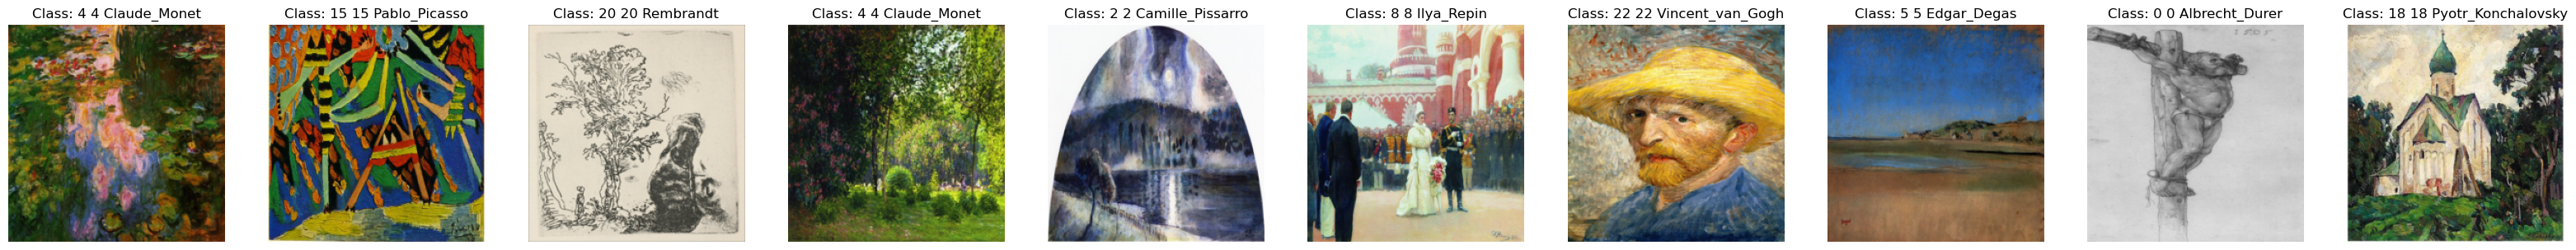

In [ ]:
# Visualize class distribution
artist_balanced_dataset.visualize_class_distribution()

# Visualize sample images
artist_balanced_dataset.visualize_samples(num_samples=10)

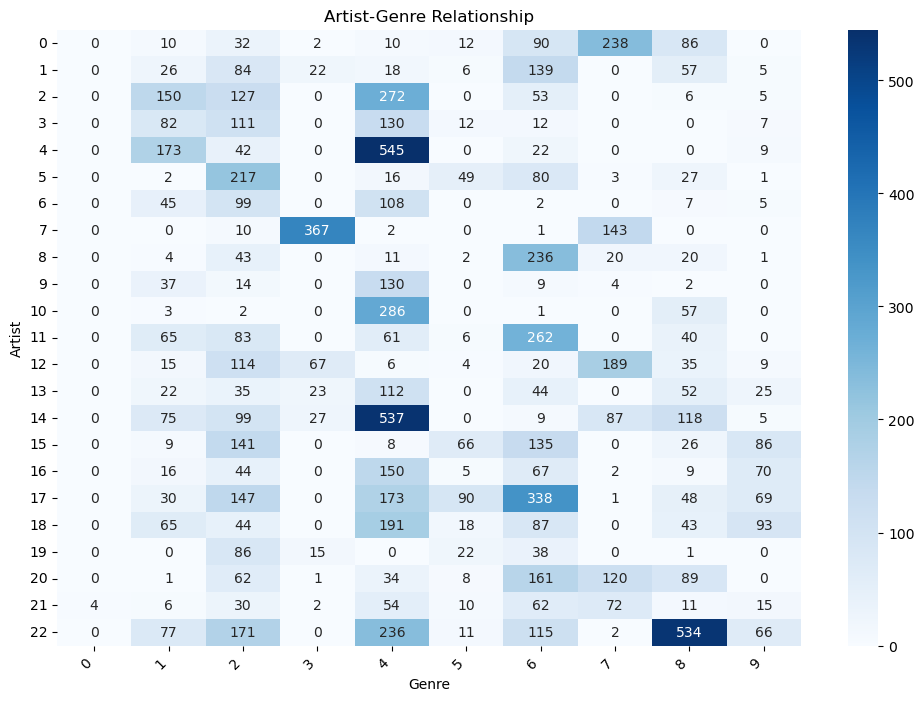

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize artist-genre relationship
def visualize_artist_genre_relationship(artist_csv, genre_csv):
    # Load datasets
    artist_data = pd.read_csv(artist_csv)
    genre_data = pd.read_csv(genre_csv)

    # Merge datasets on image path
    merged_data = artist_data.merge(genre_data, on="path")

    # Extract artist and genre relationships
    artist_genre_counts = merged_data.groupby(["class_no_x", "class_no_y"]).size().unstack(fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(artist_genre_counts, cmap="Blues", annot=True, fmt="d")
    plt.xlabel("Genre")
    plt.ylabel("Artist")
    plt.title("Artist-Genre Relationship")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# File paths
df_artist_path = artist_train_path  # Replace with actual artist CSV path
df_genre_path = genre_train_path    # Replace with actual genre CSV path

# Run visualization
visualize_artist_genre_relationship(df_artist_path, df_genre_path)


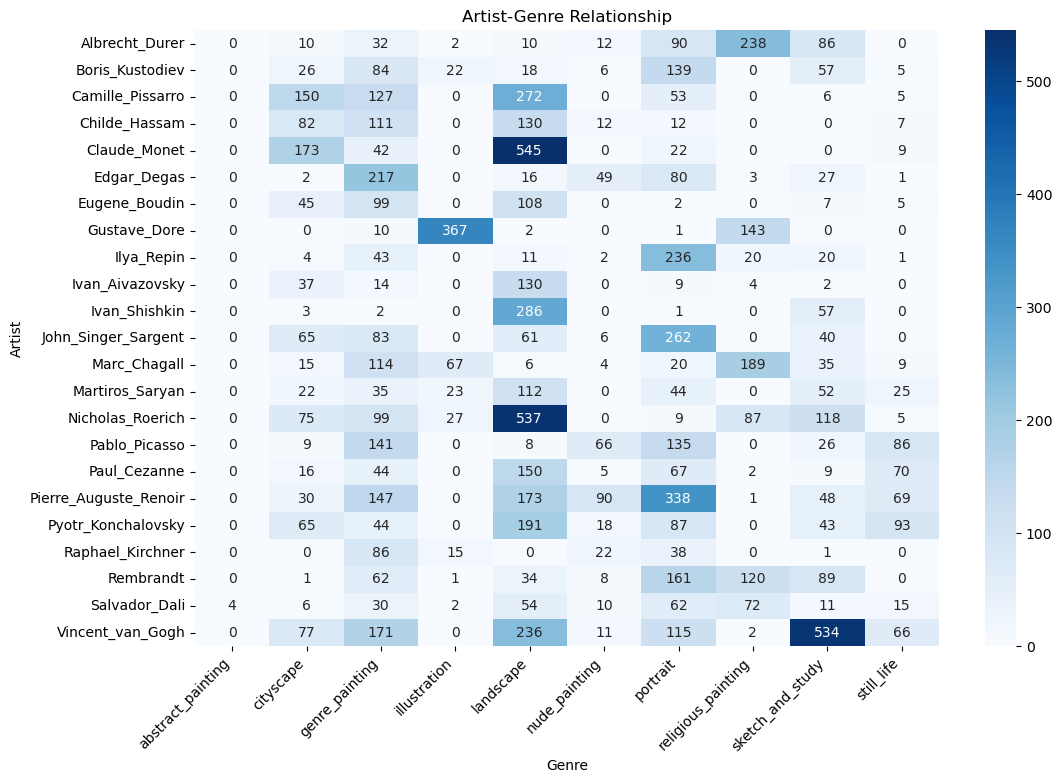

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize artist-genre relationship
def visualize_artist_genre_relationship(artist_csv, genre_csv, artist_class_txt, genre_class_txt):
    # Load datasets
    artist_data = pd.read_csv(artist_csv)
    genre_data = pd.read_csv(genre_csv)

    # Load artist and genre class data from text files and assign index as class_no
    artist_classes = pd.read_csv(artist_class_txt, header=None, names=["artist_name"])
    genre_classes = pd.read_csv(genre_class_txt, header=None, names=["genre_name"])

    # Assign class_no starting from 0
    artist_classes.reset_index(inplace=True)
    genre_classes.reset_index(inplace=True)

    # Rename index column to class_no
    artist_classes.rename(columns={"index": "class_no"}, inplace=True)
    genre_classes.rename(columns={"index": "class_no"}, inplace=True)

    # Merge datasets on image path
    merged_data = artist_data.merge(genre_data, on="path")

    # Convert class_no_x and class_no_y to integers
    merged_data["class_no_x"] = merged_data["class_no_x"].astype(int)
    merged_data["class_no_y"] = merged_data["class_no_y"].astype(int)

    # Merge to replace class_no with actual names
    merged_data = merged_data.merge(artist_classes, left_on="class_no_x", right_on="class_no", how="left", suffixes=("", "_artist"))
    merged_data = merged_data.merge(genre_classes, left_on="class_no_y", right_on="class_no", how="left", suffixes=("", "_genre"))

    # Drop unnecessary columns to prevent conflicts
    merged_data.drop(columns=["class_no", "class_no_artist", "class_no_genre"], errors="ignore", inplace=True)

    # Extract artist and genre relationships
    artist_genre_counts = merged_data.groupby(["artist_name", "genre_name"]).size().unstack(fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(artist_genre_counts, cmap="Blues", annot=True, fmt="d")
    plt.xlabel("Genre")
    plt.ylabel("Artist")
    plt.title("Artist-Genre Relationship")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# File paths
df_artist_path = artist_train_path  # Replace with actual artist CSV path
df_genre_path = genre_train_path    # Replace with actual genre CSV path
df_artist_class_txt = artist_class_path  # Artist class text file (each line is a name)
df_genre_class_txt = genre_class_path    # Genre class text file (each line is a name)

# Run visualization
visualize_artist_genre_relationship(df_artist_path, df_genre_path, df_artist_class_txt, df_genre_class_txt)


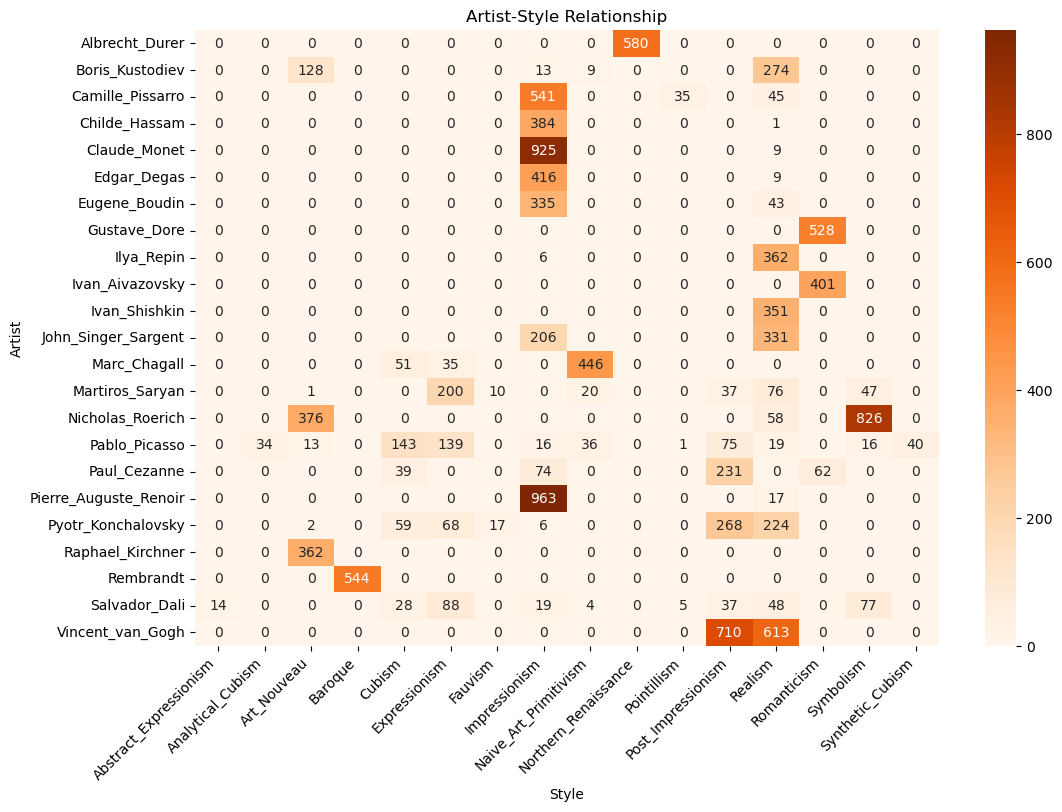

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize artist-style relationship
def visualize_artist_style_relationship(artist_csv, style_csv, artist_class_txt, style_class_txt):
    # Load datasets
    artist_data = pd.read_csv(artist_csv)
    style_data = pd.read_csv(style_csv)

    # Load artist and style class data from text files and assign index as class_no
    artist_classes = pd.read_csv(artist_class_txt, header=None, names=["artist_name"])
    style_classes = pd.read_csv(style_class_txt, header=None, names=["style_name"])

    # Assign class_no starting from 0
    artist_classes.reset_index(inplace=True)
    style_classes.reset_index(inplace=True)

    # Rename index column to class_no
    artist_classes.rename(columns={"index": "class_no"}, inplace=True)
    style_classes.rename(columns={"index": "class_no"}, inplace=True)

    # Merge datasets on image path
    merged_data = artist_data.merge(style_data, on="path")

    # Convert class_no_x and class_no_y to integers
    merged_data["class_no_x"] = merged_data["class_no_x"].astype(int)
    merged_data["class_no_y"] = merged_data["class_no_y"].astype(int)

    # Merge to replace class_no with actual names
    merged_data = merged_data.merge(artist_classes, left_on="class_no_x", right_on="class_no", how="left", suffixes=("", "_artist"))
    merged_data = merged_data.merge(style_classes, left_on="class_no_y", right_on="class_no", how="left", suffixes=("", "_style"))

    # Drop unnecessary columns to prevent conflicts
    merged_data.drop(columns=["class_no", "class_no_artist", "class_no_style"], errors="ignore", inplace=True)

    # Extract artist and style relationships
    artist_style_counts = merged_data.groupby(["artist_name", "style_name"]).size().unstack(fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(artist_style_counts, cmap="Oranges", annot=True, fmt="d")
    plt.xlabel("Style")
    plt.ylabel("Artist")
    plt.title("Artist-Style Relationship")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# File paths
df_artist_path = artist_train_path  # Replace with actual artist CSV path
df_style_path = style_train_path    # Replace with actual style CSV path
df_artist_class_txt = artist_class_path  # Artist class text file (each line is a name)
df_style_class_txt = style_class_path    # Style class text file (each line is a name)

# Run visualization
visualize_artist_style_relationship(df_artist_path, df_style_path, df_artist_class_txt, df_style_class_txt)


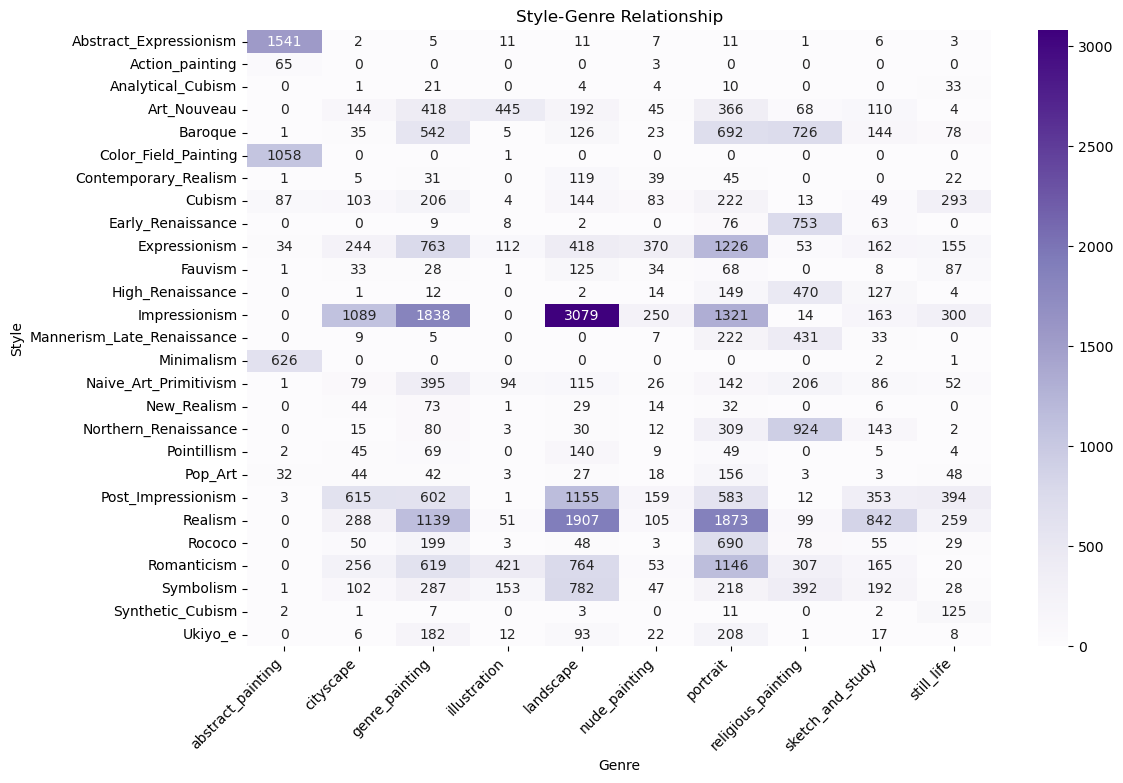

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize style-genre relationship
def visualize_style_genre_relationship(style_csv, genre_csv, style_class_txt, genre_class_txt):
    # Load datasets
    style_data = pd.read_csv(style_csv)
    genre_data = pd.read_csv(genre_csv)

    # Load style and genre class data from text files and assign index as class_no
    style_classes = pd.read_csv(style_class_txt, header=None, names=["style_name"])
    genre_classes = pd.read_csv(genre_class_txt, header=None, names=["genre_name"])

    # Assign class_no starting from 0
    style_classes.reset_index(inplace=True)
    genre_classes.reset_index(inplace=True)

    # Rename index column to class_no
    style_classes.rename(columns={"index": "class_no"}, inplace=True)
    genre_classes.rename(columns={"index": "class_no"}, inplace=True)

    # Merge datasets on image path
    merged_data = style_data.merge(genre_data, on="path")

    # Convert class_no_x and class_no_y to integers
    merged_data["class_no_x"] = merged_data["class_no_x"].astype(int)
    merged_data["class_no_y"] = merged_data["class_no_y"].astype(int)

    # Merge to replace class_no with actual names
    merged_data = merged_data.merge(style_classes, left_on="class_no_x", right_on="class_no", how="left", suffixes=("", "_style"))
    merged_data = merged_data.merge(genre_classes, left_on="class_no_y", right_on="class_no", how="left", suffixes=("", "_genre"))

    # Drop unnecessary columns to prevent conflicts
    merged_data.drop(columns=["class_no", "class_no_style", "class_no_genre"], errors="ignore", inplace=True)

    # Extract style and genre relationships
    style_genre_counts = merged_data.groupby(["style_name", "genre_name"]).size().unstack(fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(style_genre_counts, cmap="Purples", annot=True, fmt="d")
    plt.xlabel("Genre")
    plt.ylabel("Style")
    plt.title("Style-Genre Relationship")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# File paths
df_style_path = style_train_path  # Replace with actual style CSV path
df_genre_path = genre_train_path  # Replace with actual genre CSV path
df_style_class_txt = style_class_path  # Style class text file (each line is a name)
df_genre_class_txt = genre_class_path  # Genre class text file (each line is a name)

# Run visualization
visualize_style_genre_relationship(df_style_path, df_genre_path, df_style_class_txt, df_genre_class_txt)
